# Stoxx Europe 600 Banks
The main benchmark for the European banking sector is the Stoxx Europe 600 Banks sector index (ticker `SX7P`). At the moment [it comprises 48 banks](https://stoxx.com/index/sx7p/?components=true), of which 27 are from the Eurozone (Germany, France, Italy, Spain, the Netherlands, Belgium, Ireland, Finland) and 21 from outside (the UK, Switzerland, Sweden, Denmark, Norway, and Poland).

In this notebook I look at:
* the market capitalization of listed domestic companies that are part of the Stoxx Europe 600 Banks index
* the total annual and daily value of stocks traded that belong to the index
* the annual and daily turover rations of stocks traded that belong to the index
* the forward annual dividend yield of banks that are part of the index
* the forward price to earnings ratio of banks that are part of the index
* the P/B and ROEs of banks that are part of the index and their cost of equity

I created my own module called `stock_market.metrics` (which is part of this repository) where I calculate capitalization, turnover, forward dividend yields and volatility of an arbitrary stock market with the help of the [yfinance](https://pypi.org/project/yfinance/) module. I use it to provide metrics on banks that are part of the [Stoxx 600 Banks Index](https://stoxx.com/index/sx7p/).

All amounts are represented in either Billions of Euros or as percentage points. Since the index has UK, Swiss, Swedish, Danish, Norwegian, and Czech Republic banks whose stocks are denominated in respective national currencies, I covert them into Euros using the exchange rate at the end of each relevant date.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/US_Economic_Data_Analysis.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader and yfinance
# !pip install pandas-datareader -U
# !pip install yfinance -U
# !pip install eurostat -U

In [2]:
import pandas as pd
from pandas.tseries.offsets import YearBegin
import numpy as np
import scipy
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from pandas_datareader import wb
import eurostat

from datetime import date

from stock_market import metrics, currency_converters

In [3]:
# Human readable column names for DataFrames
MKT_CAP_BANKS = 'Market capitalization of Stoxx Europe 600 Banks'
MKT_CAP_TOP10_BANKS = 'Top-10 Stoxx Europe 600 Banks by market capitalization and their share of Stoxx Europe 600 Banks'
TRAD_VOL = 'Stocks traded, total value'
TRAD_VOL_BANKS_GRAPH_TITLE = 'Stoxx Europe 600 Banks ' + TRAD_VOL + ' (annualized)'
TRAD_VOL_BANKS_GRAPH_TITLE_DAILY = 'Stoxx Europe 600 Banks ' + TRAD_VOL + ' (average daily)'
TUROVER_RATIO_BANKS = 'Turnover ratio of Stoxx Europe 600 Banks (%)'
TUROVER_RATIO_BANKS_GRAPH_TITLE = 'Stocks traded, Annual ' + TUROVER_RATIO_BANKS
TUROVER_RATIO_BANKS_DAILY_GRAPH_TITLE = 'Stocks traded, Daily ' + TUROVER_RATIO_BANKS
EXCESS_RETURN_BANKS = 'Excess Annual Return of Stoxx Europe 600 Banks over 1-year Riskless rate'

# Y axis labels for graphs
LEFT_Y_AXIS_LABEL = 'Billions of Euros'

TTM_SUFFIX = ' (ttm)'
MRQ_SUFFIX = ' (mrq)'

In [4]:
start = date(2020, 1, 1)
stoxx600_banks = metrics.EuropeBanksStockMarketMetrics.get_stoxx_europe_banks_components()
cur_conv_df = currency_converters.EuroCurrencyConverter(['.L', '.SW', '.ST', '.CO', '.OL', '.PR', '.WA'], start)\
            .get_currency_conversion_df()
stoxx600_banks_metrics = metrics.EuropeBanksStockMarketMetrics(
    metrics.EuropeBanksStockMarketMetrics.tickers_to_dict(stoxx600_banks, start), None, start=start, 
    currency_conversion_df=cur_conv_df)

num_non_ea = len([ticker for ticker in stoxx600_banks
                    if stoxx600_banks_metrics.get_exchange_suffix(ticker) in cur_conv_df.columns])
print(f'Stoxx Europe 600 Banks contains {len(stoxx600_banks)} banks')
print(f'of which {len(stoxx600_banks) - num_non_ea} are in the Euro area and {num_non_ea} outside of it')

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  48 of 48 completed


Stoxx Europe 600 Banks contains 48 banks
of which 27 are in the Euro area and 21 outside of it


In [5]:
# A look-up map from ticker symbols to displayable names
names = stoxx600_banks_metrics.tickers_to_display_names(stoxx600_banks)
ticker_to_name = dict(zip(stoxx600_banks, names))

In [6]:
# Convert into billions of Euros
banks_capitalization = stoxx600_banks_metrics.get_capitalization(frequency='MS') / 1e9
banks_annual_trading_value = stoxx600_banks_metrics.get_annual_trading_value(frequency='MS') / 1e9
banks_daily_trading_value = stoxx600_banks_metrics.get_daily_trading_value(frequency='MS') / 1e9

banks_daily_turnover = stoxx600_banks_metrics.get_daily_turnover(frequency='MS')
banks_annual_turnover = stoxx600_banks_metrics.get_annual_turnover(frequency='MS')

In [7]:
stock_mkt_banks = pd.concat([banks_capitalization, banks_annual_trading_value, banks_daily_turnover], axis=1)
stock_mkt_banks.columns = [MKT_CAP_BANKS, TRAD_VOL, TUROVER_RATIO_BANKS]
stock_mkt_banks.dropna(inplace=True)

In the below table **_Stocks traded, total value_** represents a cumulative annual amount of all transactions in Stoxx Europe 600 Banks' shares. **_Turnover ratio of Stoxx Europe 600 Banks_** represents the percentage of shares outstanding that are traded per day.

In [8]:
pd.options.display.float_format = (lambda x: '{:.2%}'.format(x) if x < 5 else '€{:,.2f}bn'.format(x))
pd.options.display.max_rows = 40
stock_mkt_banks

,Market capitalization of Stoxx Europe 600 Banks,"Stocks traded, total value",Turnover ratio of Stoxx Europe 600 Banks (%)
Date,,,
2020-01-01,€956.75bn,€591.08bn,0.25%
2020-02-01,€963.11bn,€923.84bn,0.39%
2020-03-01,€651.00bn,"€1,146.51bn",0.70%
2020-04-01,€565.92bn,€672.83bn,0.47%
2020-05-01,€573.53bn,€603.03bn,0.41%
...,...,...,...
2025-03-01,"€1,532.67bn","€1,256.26bn",0.33%
2025-04-01,"€1,412.75bn","€1,319.28bn",0.37%
2025-05-01,"€1,554.16bn","€1,013.37bn",0.26%


## Market capitalization of Stoxx Europe 600 Banks

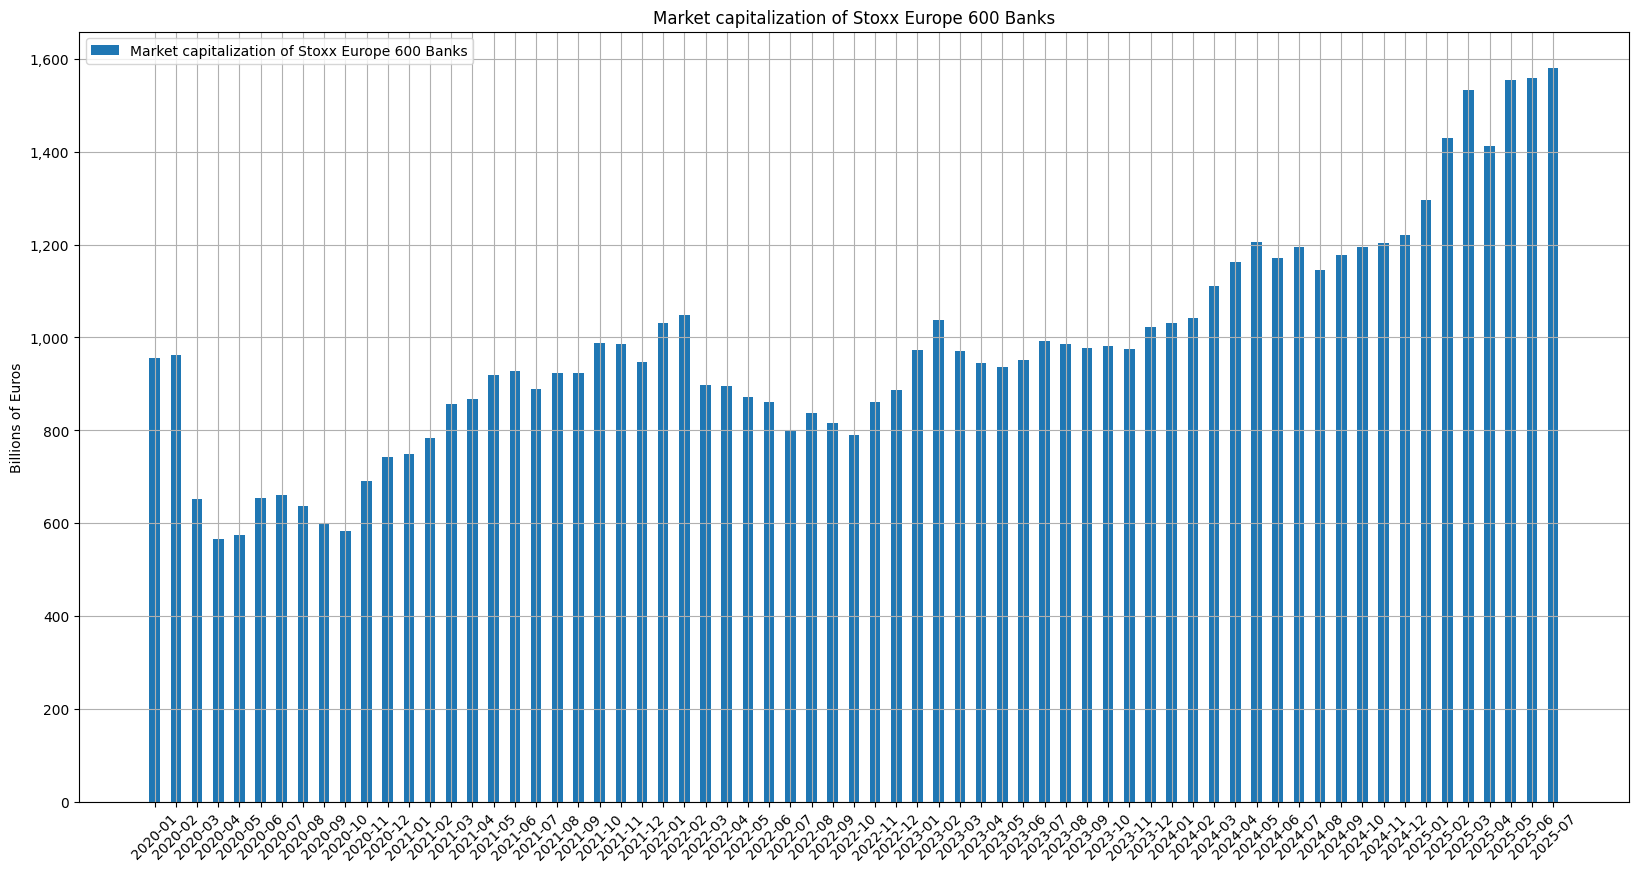

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x=range(len(stock_mkt_banks)), height=stock_mkt_banks.iloc[:,0], color='#1f77b4', width=0.5,
       label=MKT_CAP_BANKS)
ax.legend(loc='upper left')
ax.title.set_text(MKT_CAP_BANKS)
ax.grid(True)
_ = ax.set_xticks(range(len(stock_mkt_banks)), stock_mkt_banks.index)
_ = ax.set_xticklabels(stock_mkt_banks.index.strftime('%Y-%m'), rotation=45)
#ax.set_yticks(np.arange(0, 56000, 5000))
ax.set_ylabel(LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')

### Top-10 banks  by their capitalization and their share in the overall capitalization of Stoxx Europe 600 Banks

In [10]:
top10_today = stoxx600_banks_metrics.get_top_n_capitalization_companies_for_day(
    10, merge_additional_share_classes=True)
top10_last_month = stoxx600_banks_metrics.get_top_n_capitalization_companies_for_month(
    10, stoxx600_banks_metrics.data.index[-1] - pd.DateOffset(months=+1))
top10_year_ago = stoxx600_banks_metrics.get_top_n_capitalization_companies_for_month(
    10, stoxx600_banks_metrics.data.index[-1] - pd.DateOffset(months=+12))

# Calculate metrics for the previous 4 years
num_years = 4
years = list(range(stoxx600_banks_metrics.data.index[-1].year-num_years, stoxx600_banks_metrics.data.index[-1].year))
top10_last_n_years = [stoxx600_banks_metrics.get_top_n_capitalization_companies_for_year(10, date(year, 1, 1)) for year in years]

In [11]:
# Convert into Billions of Euros
top10 = list(map(lambda df: df.Capitalization, top10_last_n_years))
top10.append(top10_today.Capitalization)
top10 = pd.concat(top10, axis=1) / 1e9
columns = [stoxx600_banks_metrics.CAPITALIZATION + f' in {year}' for year in years]
columns.append(' now')
top10.columns = columns

top10_pct = list(map(lambda df: df.iloc[:,1], top10_last_n_years))
top10_pct.append(top10_today.iloc[:,1])
top10_pct = pd.concat(top10_pct, axis=1)

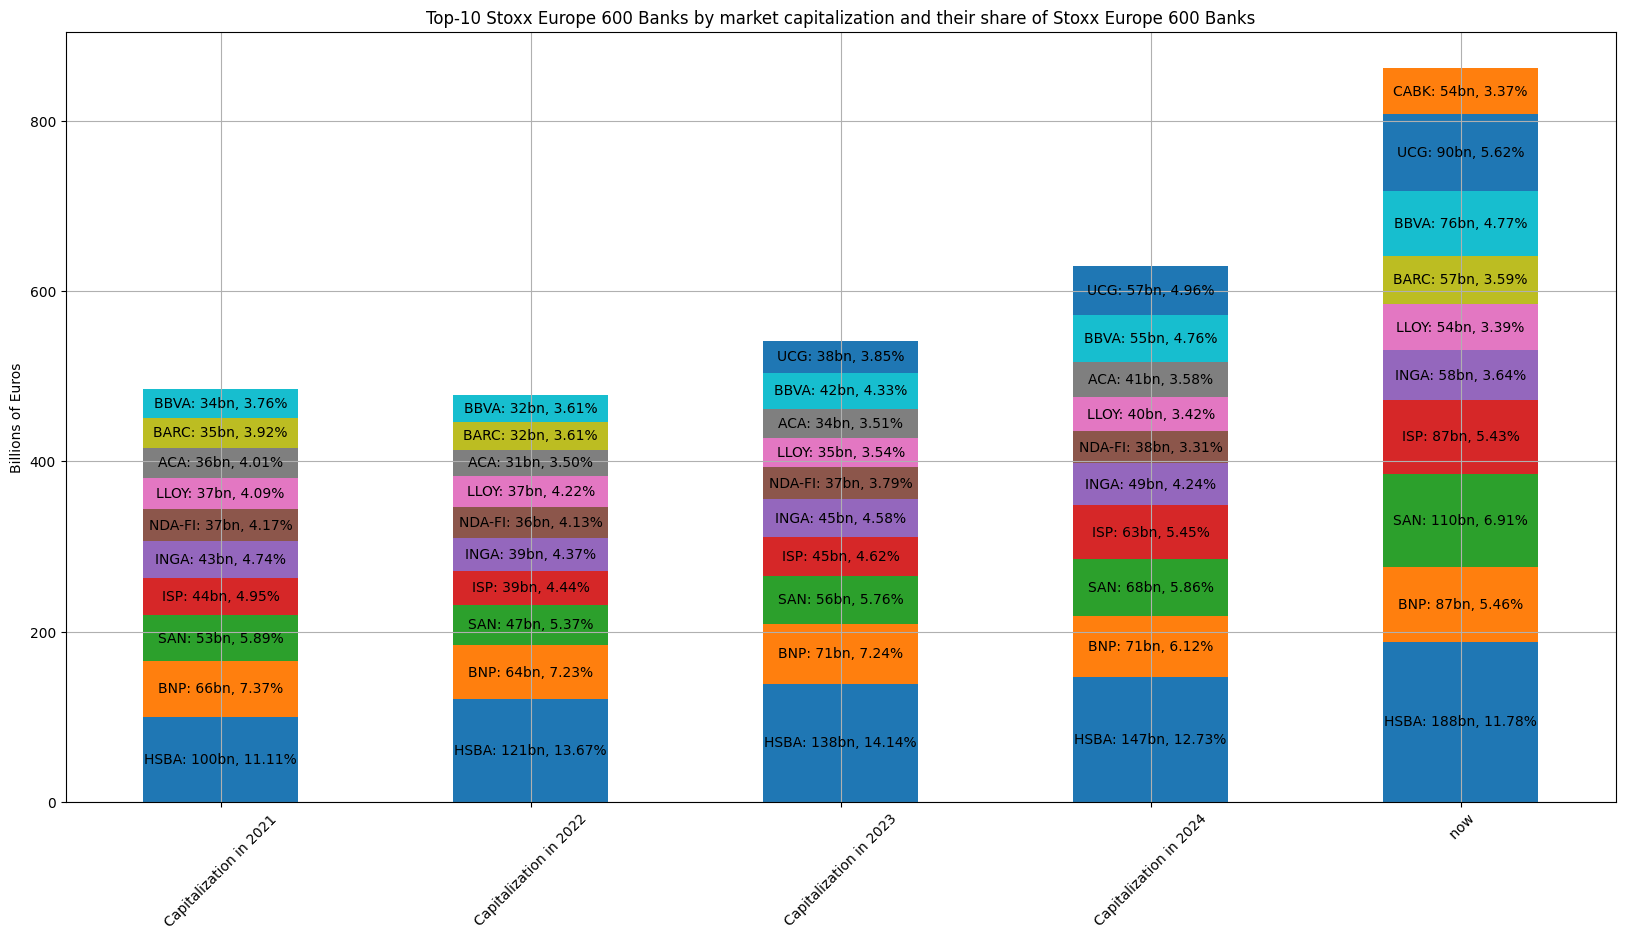

In [12]:
ax = top10.T.plot.bar(figsize=(20,10), grid=True, title=MKT_CAP_TOP10_BANKS,
                      stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.get_legend().remove()
for c in ax.containers:
    labels = [c.get_label().split('.')[0] + f': {a:,.0f}bn, {top10_pct.loc[c.get_label()].iloc[i]:.2%}'
              if a else '' for i, a in enumerate(c.datavalues)]
    ax.bar_label(c, labels=labels, label_type="center")

### Capitalization: Last Business Day vs. Previous Month's Average

In [13]:
top10_now = pd.concat([top10_last_month.Capitalization, top10_today.Capitalization], axis=1) / 1e9
top10_now.columns = [stoxx600_banks_metrics.CAPITALIZATION + sfx for sfx in [' last month', ' now']]
top10_today_pct = pd.concat([top10_last_month.iloc[:,1], top10_today.iloc[:,1]], axis=1)

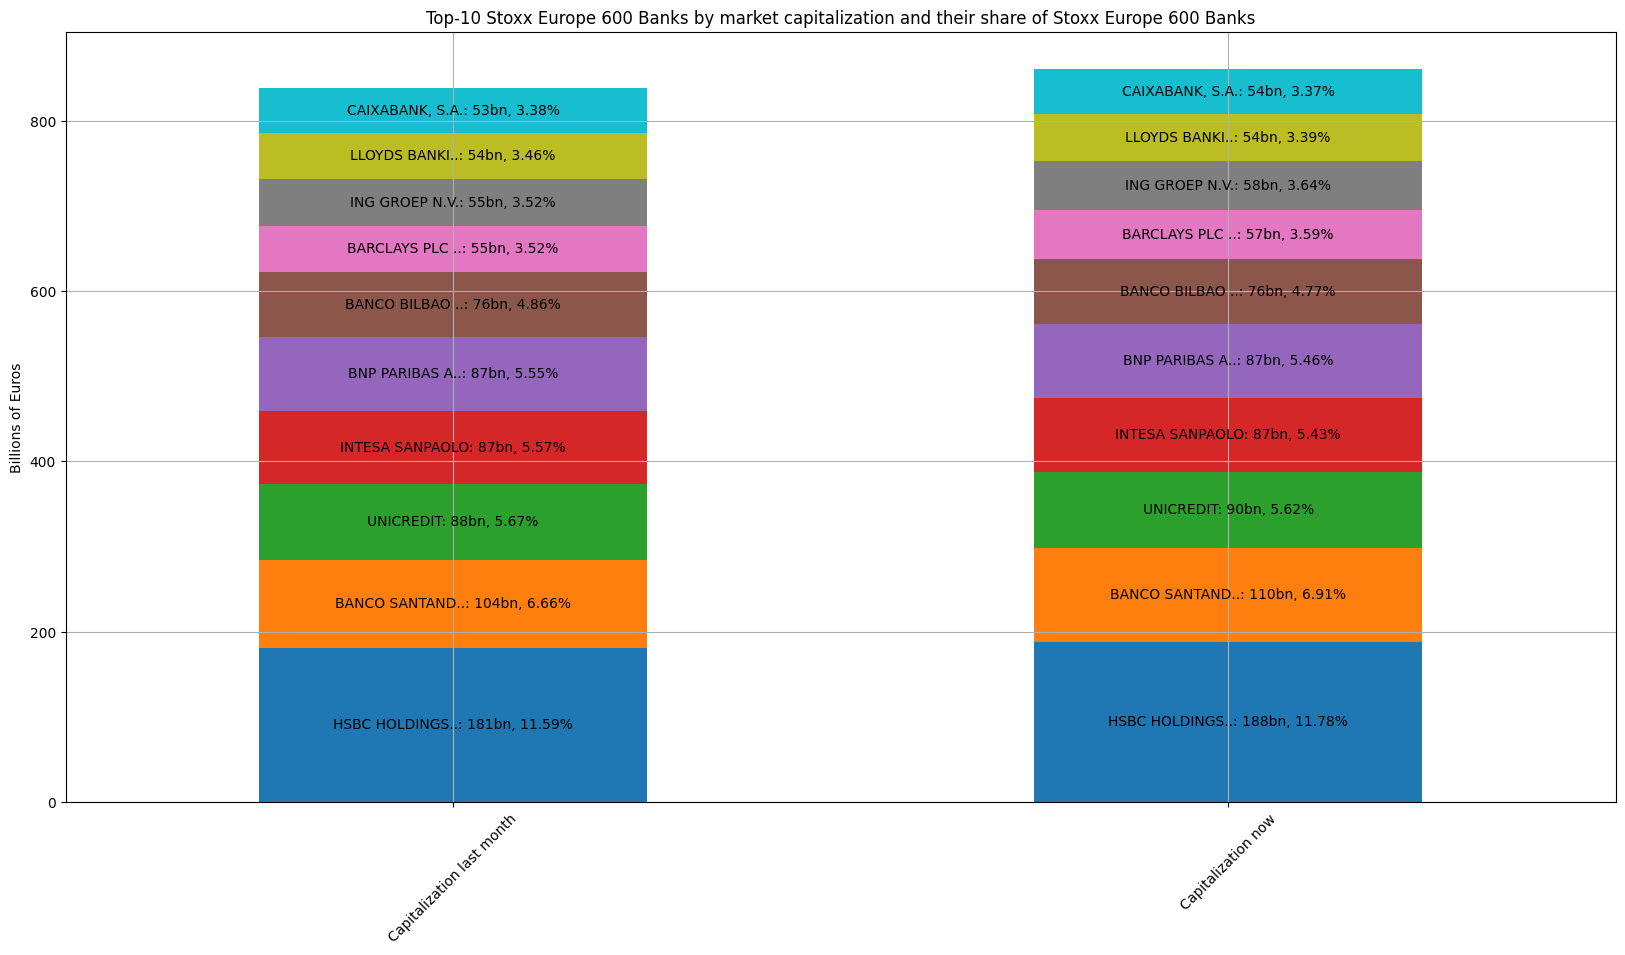

In [14]:
ax = top10_now.T.plot.bar(figsize=(20,10), grid=True, title=MKT_CAP_TOP10_BANKS,
                          stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.get_legend().remove()
for c in ax.containers:
    labels = [ticker_to_name[c.get_label()] + f': {a:,.0f}bn, {top10_today_pct.loc[c.get_label()].iloc[i]:.2%}'
              if a else '' for i, a in enumerate(c.datavalues)]
    ax.bar_label(c, labels=labels, label_type="center")

### Capitalization: Last Business Day vs. Average from Same Month Last Year

In [15]:
top10_now = pd.concat([top10_year_ago.Capitalization, top10_today.Capitalization], axis=1) / 1e9
top10_now.columns = [stoxx600_banks_metrics.CAPITALIZATION + sfx for sfx in [' year ago', ' now']]
top10_today_pct = pd.concat([top10_year_ago.iloc[:,1], top10_today.iloc[:,1]], axis=1)

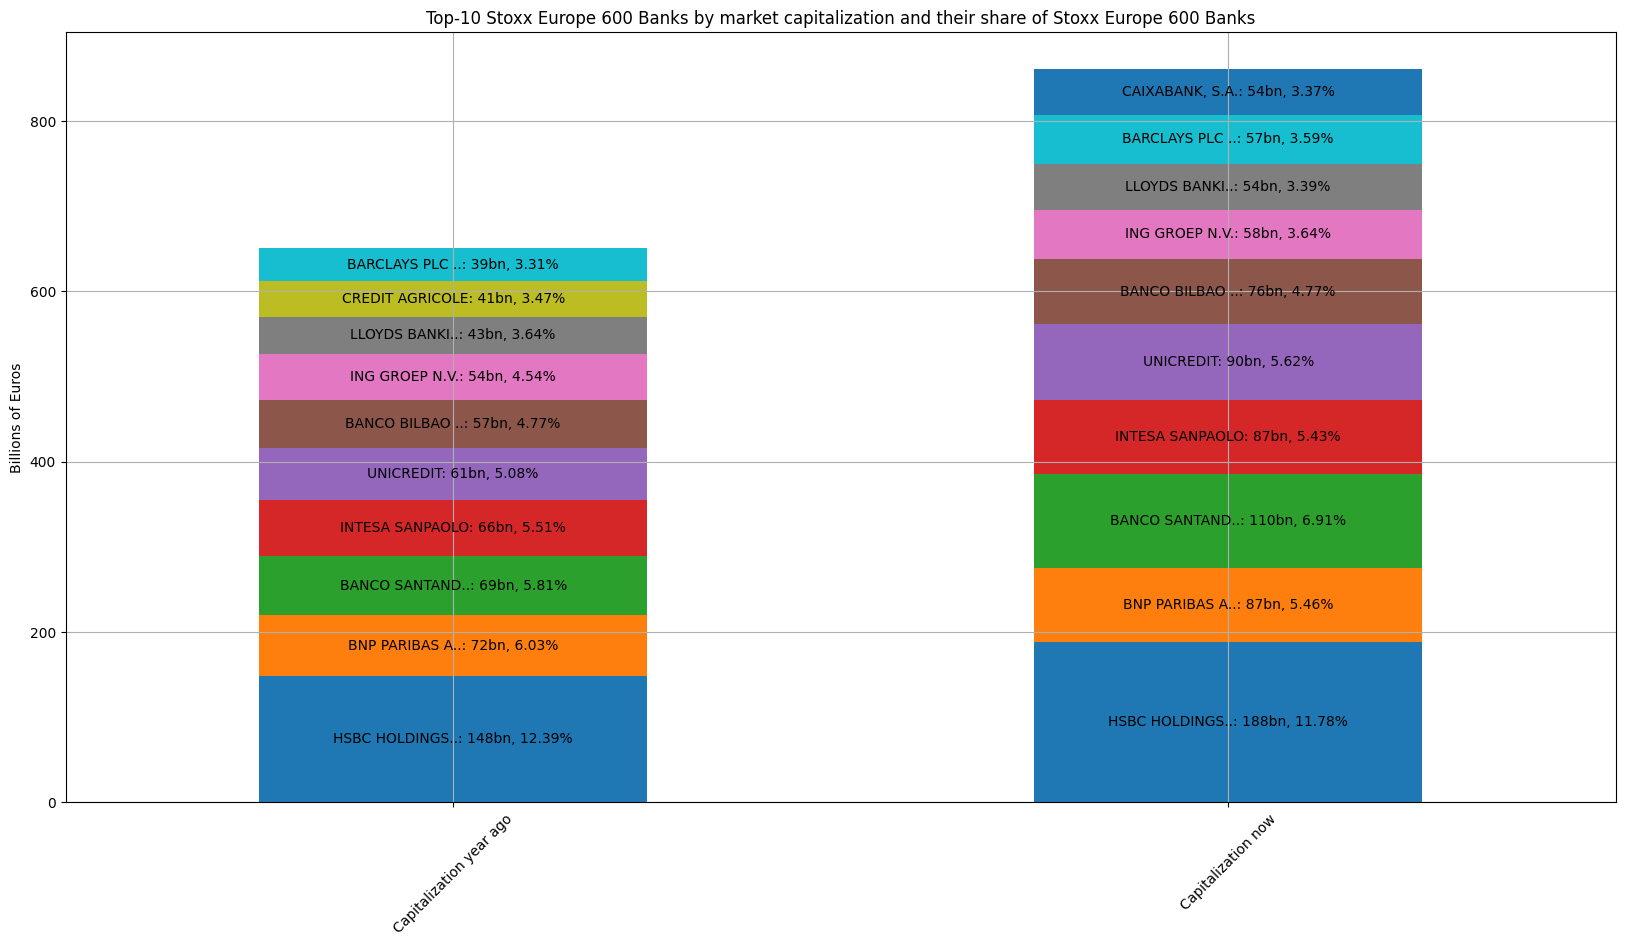

In [16]:
ax = top10_now.T.plot.bar(figsize=(20,10), grid=True, title=MKT_CAP_TOP10_BANKS,
                          stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.get_legend().remove()
for c in ax.containers:
    labels = [ticker_to_name[c.get_label()] + f': {a:,.0f}bn, {top10_today_pct.loc[c.get_label()].iloc[i]:.2%}'
              if a else '' for i, a in enumerate(c.datavalues)]
    ax.bar_label(c, labels=labels, label_type="center")

In [17]:
print('The capitalization of Top-10 changed by '
      f'{(top10_today.Capitalization.sum()-top10_year_ago.Capitalization.sum())/top10_year_ago.Capitalization.sum():+.2%} from a year ago')

The capitalization of Top-10 changed by +32.25% from a year ago


In [18]:
print(f'The capitalization of Stoxx Europe 600 banks on {stoxx600_banks_metrics.capitalization.index[-1]:%Y-%m-%d} is '
      f'€{stoxx600_banks_metrics.capitalization.iloc[-1,0]/1e9:.3f}bn')

The capitalization of Stoxx Europe 600 banks on 2025-07-17 is €1595.793bn


In [19]:
dt_year_ago = pd.Timestamp((stoxx600_banks_metrics.data.index[-1] - pd.DateOffset(months=+12)).date().replace(day=1))
cap_year_ago = banks_capitalization.loc[dt_year_ago]
pct_change_over_year_all = (stoxx600_banks_metrics.capitalization.iloc[-1,0]/1e9 - cap_year_ago) / cap_year_ago
print(f'It changed by {pct_change_over_year_all:+.2%} from a year ago')
print(f'The capitalization of Stoxx Europe 600 banks in {dt_year_ago:%Y-%m} was €{cap_year_ago:.3f}bn')

It changed by +33.62% from a year ago
The capitalization of Stoxx Europe 600 banks in 2024-07 was €1194.306bn


## Total annual and daily value of Stoxx Europe 600 Banks stocks traded 
For Stoxx Europe 600 banks I depict average daily trading values over each month. In the first graph I show average daily volumes per month, in the second I show average daily volues per month scaled to annual ammounts.

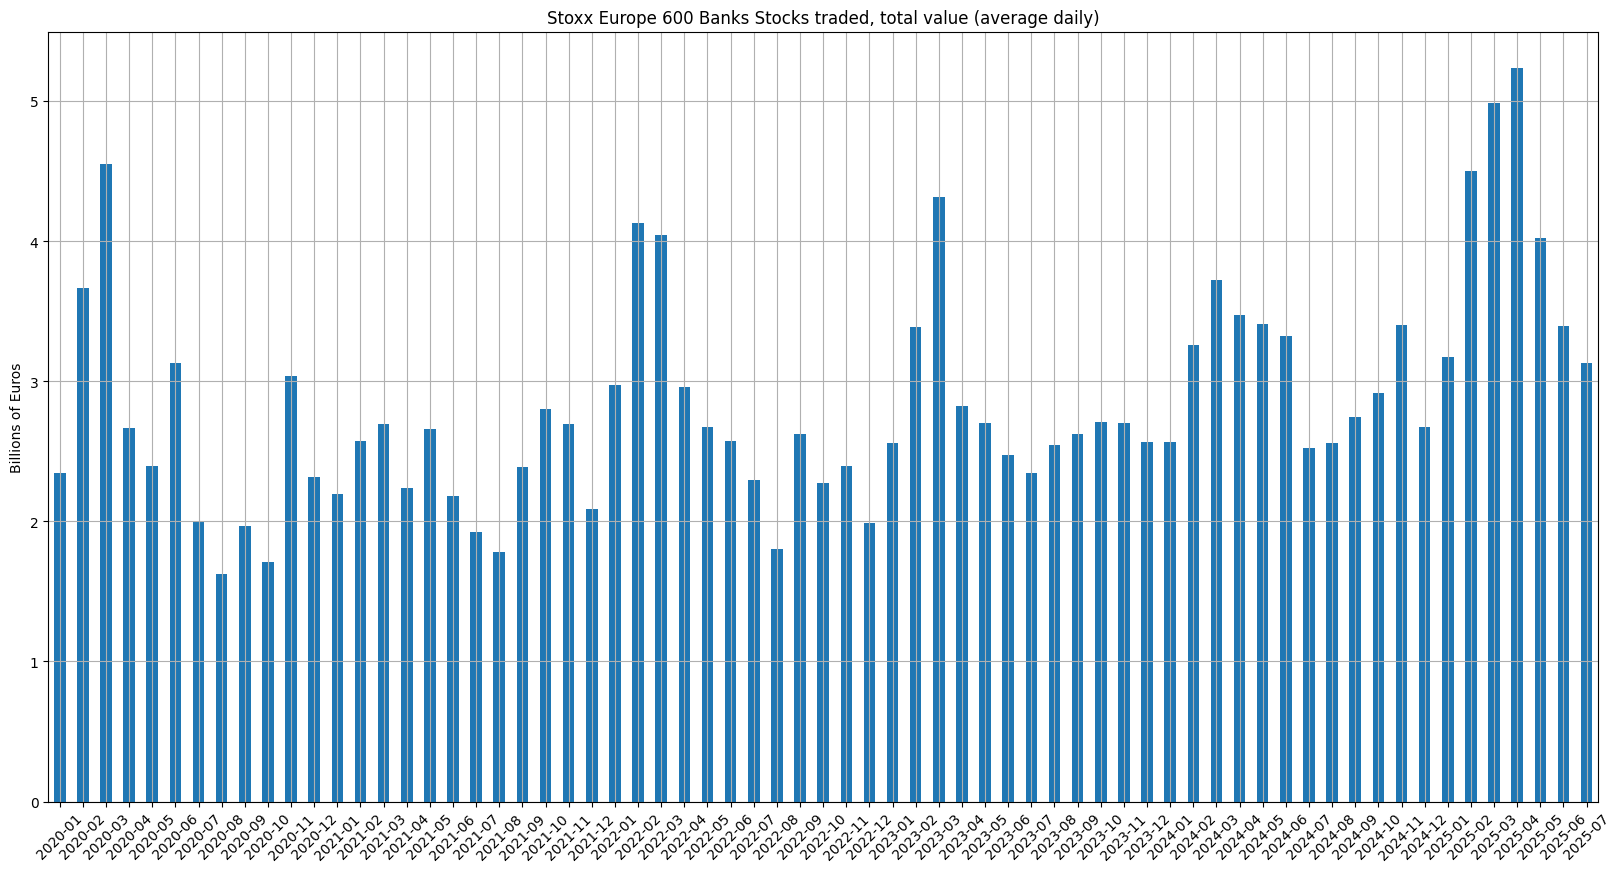

In [20]:
ax = banks_daily_trading_value.plot.bar(figsize=(20,10), grid=True, ylabel=LEFT_Y_AXIS_LABEL,
                                        title=TRAD_VOL_BANKS_GRAPH_TITLE_DAILY, color='#1f77b4',
                                        xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, banks_daily_trading_value.index)))

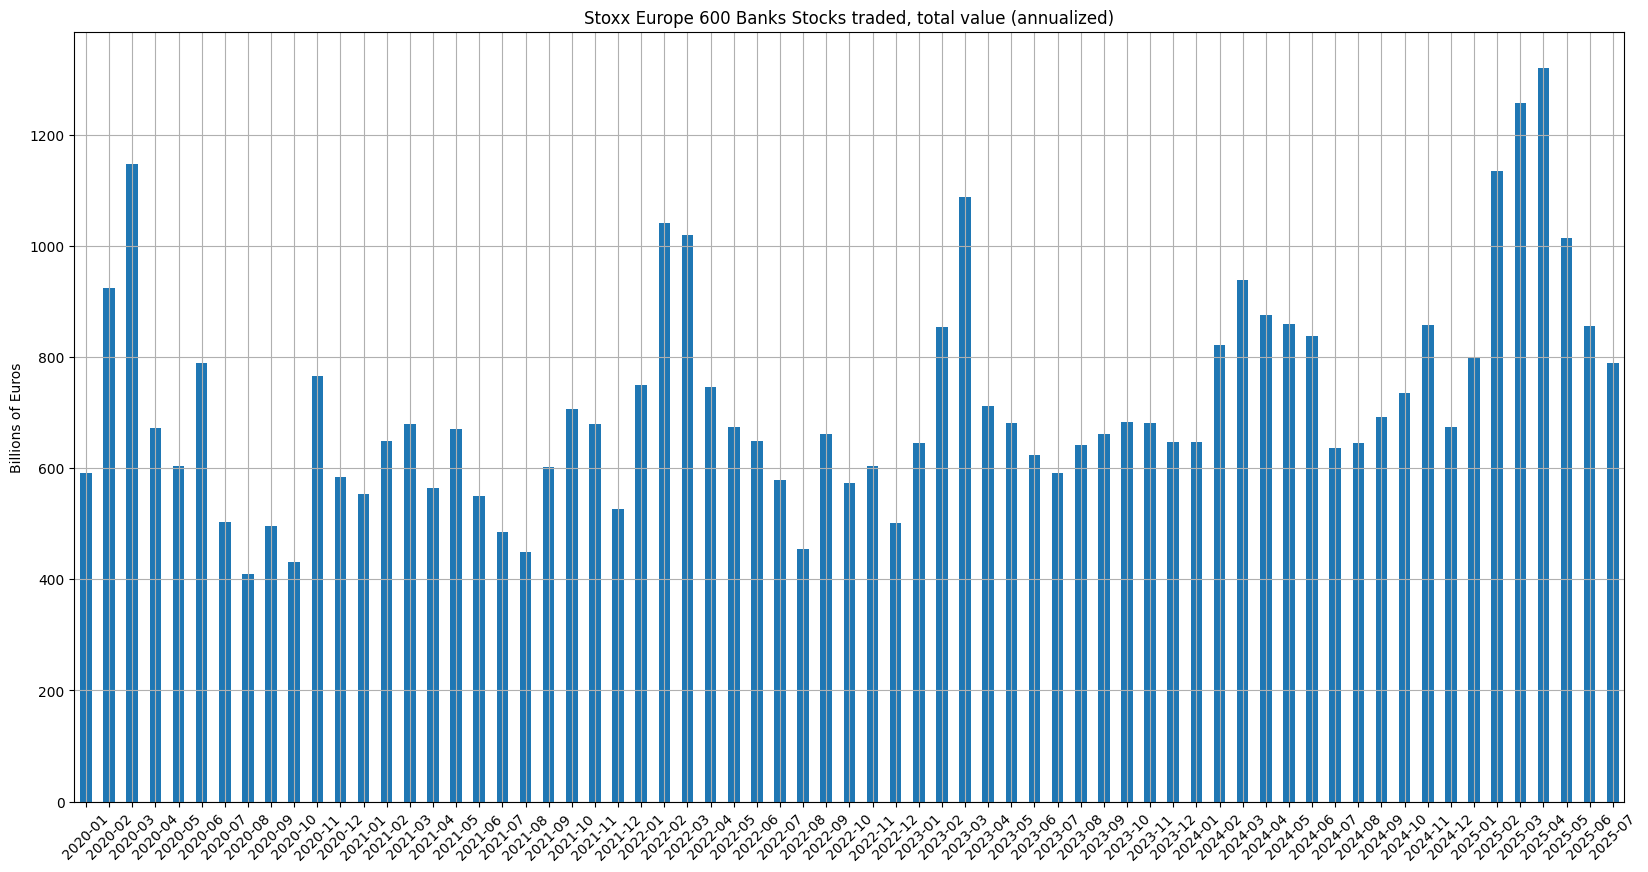

In [21]:
ax = banks_annual_trading_value.plot.bar(figsize=(20,10), grid=True, ylabel=LEFT_Y_AXIS_LABEL,
                                         title=TRAD_VOL_BANKS_GRAPH_TITLE, color='#1f77b4',
                                         xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, banks_annual_trading_value.index)))

## Stocks traded, annual and daily turnover ratios of Stoxx Europe 600 Banks shares to their capitalization
In this section of the notebook I look at the turnover ratio of Stoxx Europe 600 Banks shares traded divided by their market capitalization. The value is annualized by multiplying the monthly average by 12.

If you divide the number for a given year by 252 (the approximate number of trading days), you obtain the percentage of shares that are traded in one day. This ranges between 0.2% and 1%. And such a small fraction of traded shares determine the capitalization of the whole firm.

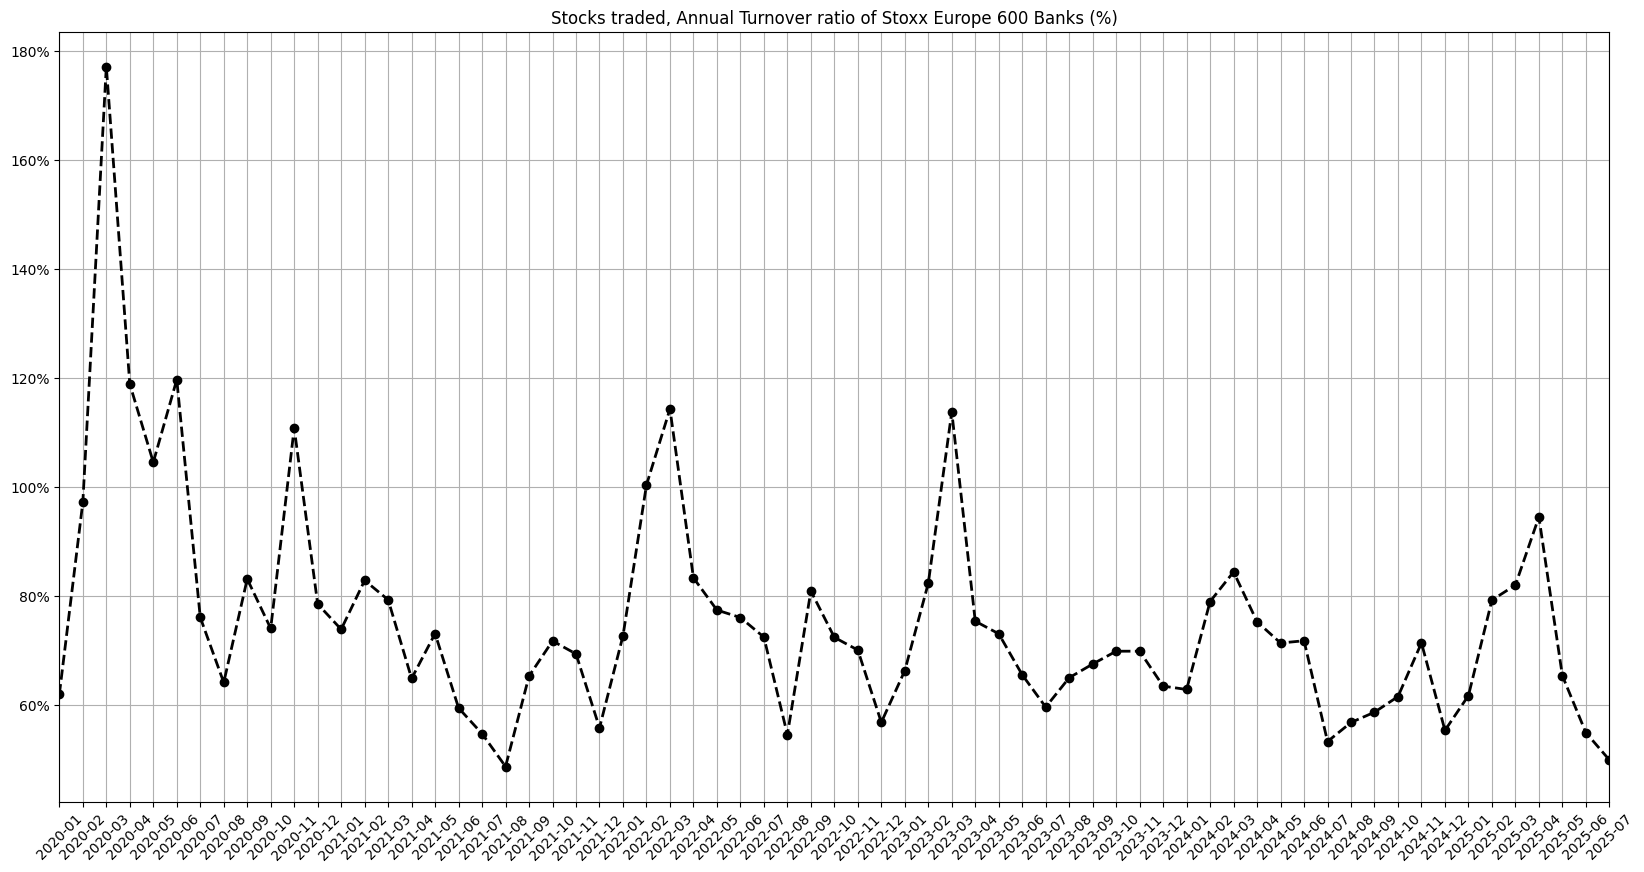

In [22]:
ax = banks_annual_turnover.dropna().plot(figsize=(20,10), grid=True, title=TUROVER_RATIO_BANKS_GRAPH_TITLE,
                                         color='k', marker='o', linestyle='--', linewidth=2,
                                         xticks=banks_annual_turnover.index, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, banks_annual_turnover.index)))

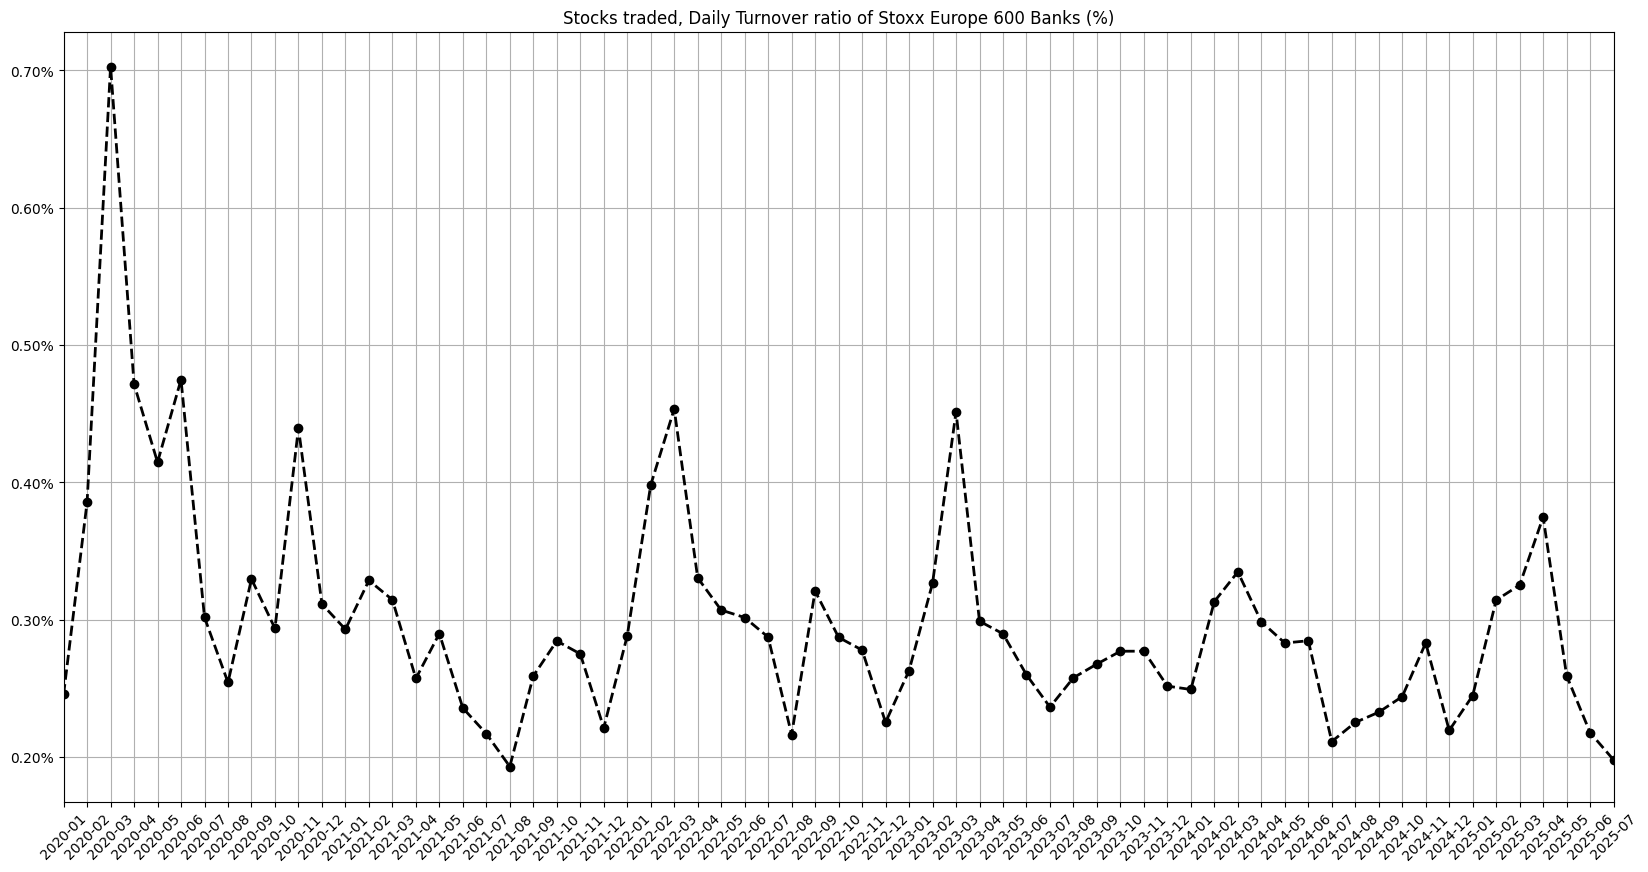

In [23]:
ax = banks_daily_turnover.plot(figsize=(20,10), grid=True,
                               title=TUROVER_RATIO_BANKS_DAILY_GRAPH_TITLE, color='k', marker='o', linestyle='--',
                               linewidth=2, xticks=banks_daily_turnover.index, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, banks_daily_turnover.index)))

## Forward annual dividend yield of Stoxx Europe 600 Banks

In [24]:
print(f'Stoxx Europe 600 banks forward dividend yield on {stoxx600_banks_metrics.data.index[-1]:%Y-%m-%d} is '
      f'{stoxx600_banks_metrics.forward_dividend_yield:.5}%')

Stoxx Europe 600 banks forward dividend yield on 2025-07-17 is 5.2992%


## Forward Price to Earnings ratio of Stoxx Europe 600 Banks

In [25]:
print(f'Stoxx Europe 600 banks forward P/E on {stoxx600_banks_metrics.data.index[-1]:%Y-%m-%d} is '
      f'{stoxx600_banks_metrics.forward_PE:.2f}')

Stoxx Europe 600 banks forward P/E on 2025-07-17 is 12.27


## Price to Book, Return on Equity, and Cost of Capital of Stoxx Europe 600 Banks
One of the most frequently used tools for analyzing banks is their P/B and ROE ratios. Being traditional businesses for which book value is a meaningful metric, the following equation holds for banks:
$$\frac{P}{B}=\frac{ROE}{\text{Cost-of-equity} - g}$$
where:
* `P` is the market price of a bank's equity
* `B` is the book value of the bank's equity
* `ROE` is its return on equity
* `g` is an expected nominal growth of the bank's earnings

Therefore, a popular way to compare banks is to plot their P/B (price-to-book) ratios against their ROEs (return on equity). Banks whose ROE exceeds their cost of equity tend to have a P/B ratio greater than 1. If the cost of equity and earnings growth were the same for all banks, the points on this graph would form a line. However, since the cost of equity and earnings prospects differ slightly among banks, this is not the case. Still, for banks that are part of Stoxx Europe 600 banks, the points are fairly close, implying they have a similar cost of equity. Their approximate cost of equity can be derived from the above equation.

In the remainder of this notebook I will plot this for Stoxx Europe 600 Banks and derive their approximate cost of equity. As an approximation of `g`, I will use annualized _nominal_ GDP growth rate in the EU from the last quarter. While incorrect for an individual bank, it is approximately correct as an average for the banking industry. I use P/B values based on the book value as reported in the most recent quarter (MRQ) and ROE based on the trailing twelve months (TTM).


I plot a linear regression line that shows a linear dependency between ROE and P/B values for the banks in the sample. The bigger the slope of the regression line, the smaller the cost of equity.

In [26]:
roe_pb = stoxx600_banks_metrics.get_roe_and_pb(stoxx600_banks).dropna()
slope, intercept, rvalue, pvalue = scipy.stats.linregress(roe_pb.iloc[:,0].to_list(), roe_pb.iloc[:,1].to_list())[0:4]

In [27]:
# Approximate g
nominal_gdp = eurostat.get_data_df('namq_10_gdp', filter_pars={
    'startPeriod': start, 'unit': 'CP_MEUR', 's_adj': 'SCA', 'na_item': 'B1GQ', 'geo': 'EU27_2020'}).iloc[:, 4:]
nominal_gdp = nominal_gdp.set_index(nominal_gdp.columns[0]).T
nominal_gdp = nominal_gdp.set_axis(pd.DatetimeIndex(nominal_gdp.index, 'QS')).dropna()
nominal_gdp_quarterly = (nominal_gdp/nominal_gdp.shift(1)).pow(4) - 1
g = nominal_gdp_quarterly.iloc[-1,0]

Defining two helper functions for ease of reuse:
* One to display ROE to P/B charts
* Another to display derived cost of equity and sensitivity

In [28]:
def display_roe_pb(roe_pb_df, roe_cutoff=None, pb_cutoff=None, slope_intercept_r_p_value=None, expand_tickers=True):
    """
    Plots a ROE to P/B chart based on the DataFrame object 'roe_pb_df'

    :param roe_pb_df: A DataFrame index by ticker symbols and having two columns: ROE and P/B
    :param roe_cutoff: a pair designating the minimum and maximum ROE values to display
    :param pb_cutoff: a single value designating the maximum P/B value to display
    :param slope_intercept_r_p_value: a 4 value tuple to use for displaying a regression line, if None then
                                      a new linear regression tuple will be calculated based on the subset
                                      meeting the cutoff criteria specified by 'roe_cutoff' and 'pb_cutoff'
    :param expand_tickers: a boolean determining whether to convert ticker symbols into displayable company names
    :returns: a 5 value tuple comprising a DataFrame that meets the cut-off criteria and linear regression values
    """
    assert not (bool(roe_cutoff) ^ bool(pb_cutoff)), 'Either both cutoff values need to be provided or none'
    if roe_cutoff:
        roe_cutoff_min, roe_cutoff_max = roe_cutoff
        roe_pb_df = roe_pb_df.loc[(roe_pb.ROE < roe_cutoff_max) & (roe_pb.ROE > roe_cutoff_min) & (roe_pb['P/B'] < pb_cutoff)]

    slope, intercept, rvalue, pvalue = slope_intercept_r_p_value if slope_intercept_r_p_value else \
                    scipy.stats.linregress(roe_pb_df.iloc[:,0].to_list(), roe_pb_df.iloc[:,1].to_list())[0:4]

    fig, ax = plt.subplots(figsize=(20, 10))
    sc = ax.scatter(x=roe_pb_df.iloc[:,0], y=roe_pb_df.iloc[:,1])

    x_min = roe_pb_df.iloc[:,0].min()
    ax.axline((x_min, intercept + slope * x_min), slope=slope, linestyle='--', color='k', linewidth=.5)

    labels = [f'Slope = {slope/100:.3f}', f'$R^2$ = {rvalue**2:.3f}', f'p-value = {pvalue:.2g}']
    ax.legend([ax.plot([],[])[0] for _ in labels], labels, handlelength=0, handleheight=0, handletextpad=0)

    # Add labels to designate each bank
    for ticker, (roe, pb) in roe_pb_df.iterrows():
        plt.text(roe, pb, ticker_to_name[ticker] if expand_tickers else ticker, ha='left', va='bottom')
    
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.set_xlabel(roe_pb.columns[0] + TTM_SUFFIX)
    ax.set_ylabel(roe_pb.columns[1] + MRQ_SUFFIX)
    ax.set_title('Price to Book vs ROE of European Banks'
                 +  (f' (subset: {roe_cutoff_min:.0%}% < ROE < {roe_cutoff_max:.0%} and P/B < {pb_cutoff})' if roe_cutoff else '')
                 + f' on {stoxx600_banks_metrics.capitalization.index[-1]:%Y-%m-%d}')
    ax.grid(True)
    return (roe_pb_df, slope, intercept, rvalue, pvalue)

def print_cost_of_equity(roe_pb_df, slope, g):
    print(f'The sensitivity of P/B to ROE for European banks: {slope/100:.2f}\n'
          f"This means that for every percentage point improvement in ROE, the bank's P/B increases by {slope/100:.2f}\n")
    print(f'From the above equation it also means that an approximate cost of equity for these banks is: {1./slope + g:.2%}')
    print(roe_pb_df.index.to_list())

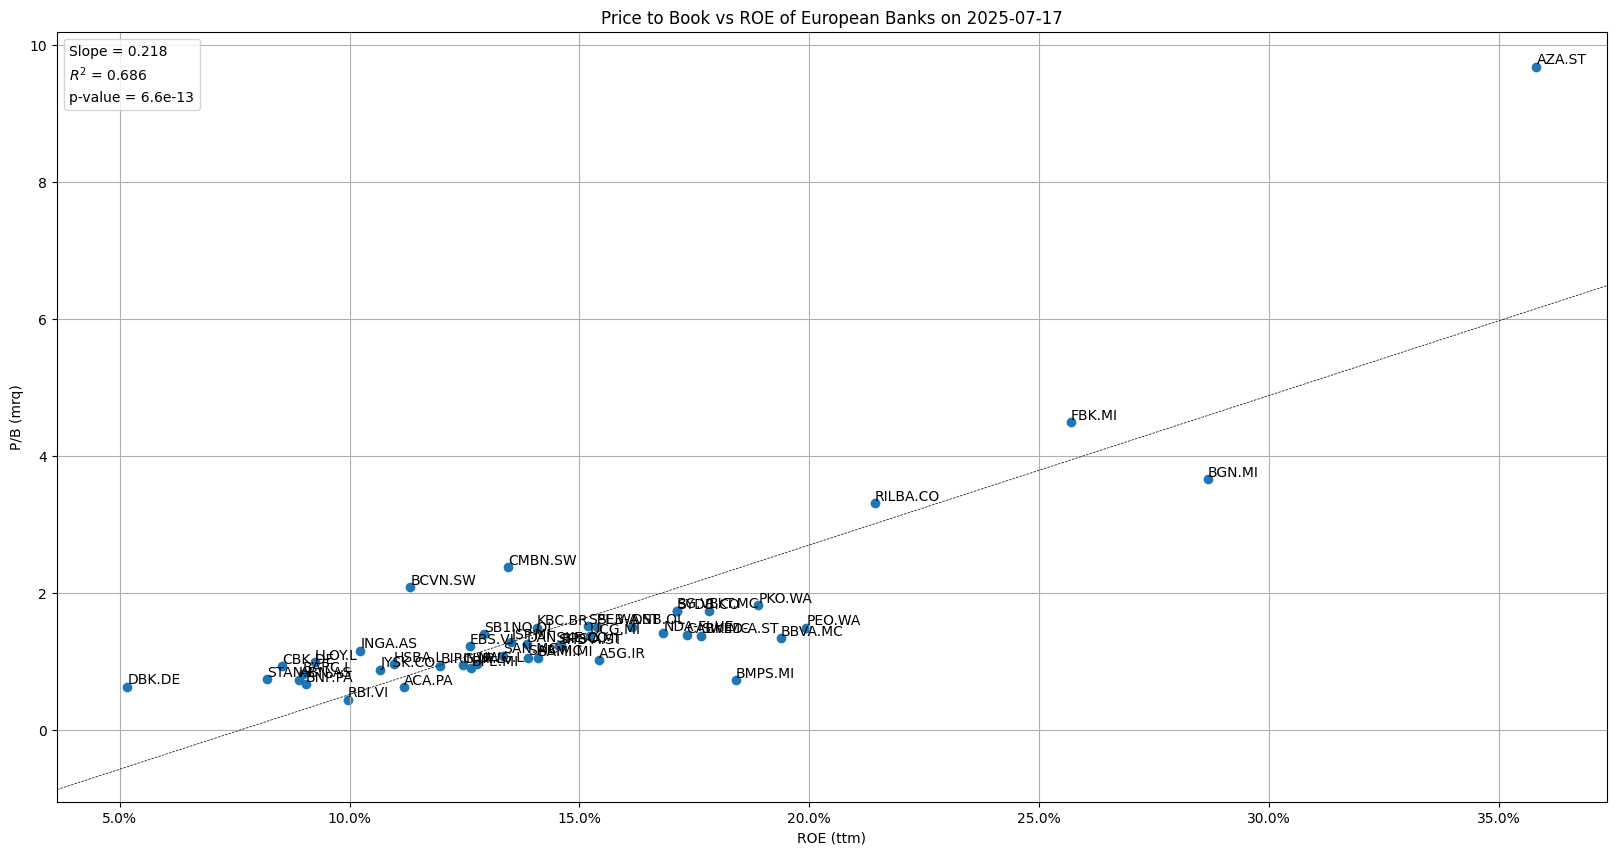

In [29]:
_ = display_roe_pb(roe_pb, slope_intercept_r_p_value=(slope, intercept, rvalue, pvalue), expand_tickers=False)

In [30]:
print_cost_of_equity(roe_pb, slope, g)

The sensitivity of P/B to ROE for European banks: 0.22
This means that for every percentage point improvement in ROE, the bank's P/B increases by 0.22

From the above equation it also means that an approximate cost of equity for these banks is: 9.60%
['INGA.AS', 'ABN.AS', 'DBK.DE', 'CBK.DE', 'BNP.PA', 'ACA.PA', 'KBC.BR', 'BIRG.IR', 'A5G.IR', 'BBVA.MC', 'BKT.MC', 'CABK.MC', 'SAB.MC', 'SAN.MC', 'EBS.VI', 'BG.VI', 'RBI.VI', 'NDA-FI.HE', 'ISP.MI', 'UCG.MI', 'FBK.MI', 'BAMI.MI', 'BPE.MI', 'BMPS.MI', 'BPSO.MI', 'BGN.MI', 'HSBA.L', 'BARC.L', 'LLOY.L', 'NWG.L', 'INVP.L', 'STAN.L', 'BCVN.SW', 'CMBN.SW', 'SEB-A.ST', 'SWED-A.ST', 'SHB-A.ST', 'AZA.ST', 'DANSKE.CO', 'SYDB.CO', 'JYSK.CO', 'RILBA.CO', 'DNB.OL', 'SB1NO.OL', 'PEO.WA', 'PKO.WA', 'SPL.WA']


The R<sup>2</sup> of more than 0.5 indicates a significant linear dependence of a bank's price-to-book ratio on its ROE. The p-value of 0.00000001 provides sufficient evidence to reject the null hypothesis that there is no correlation between banks' price-to-book ratios and their ROEs.

Now let's zoom into the cluster of banks with ROE between 0% and 20% and P/B less than 3. I will also construct a regression line to determine the sensitivity of P/B to ROE changes.

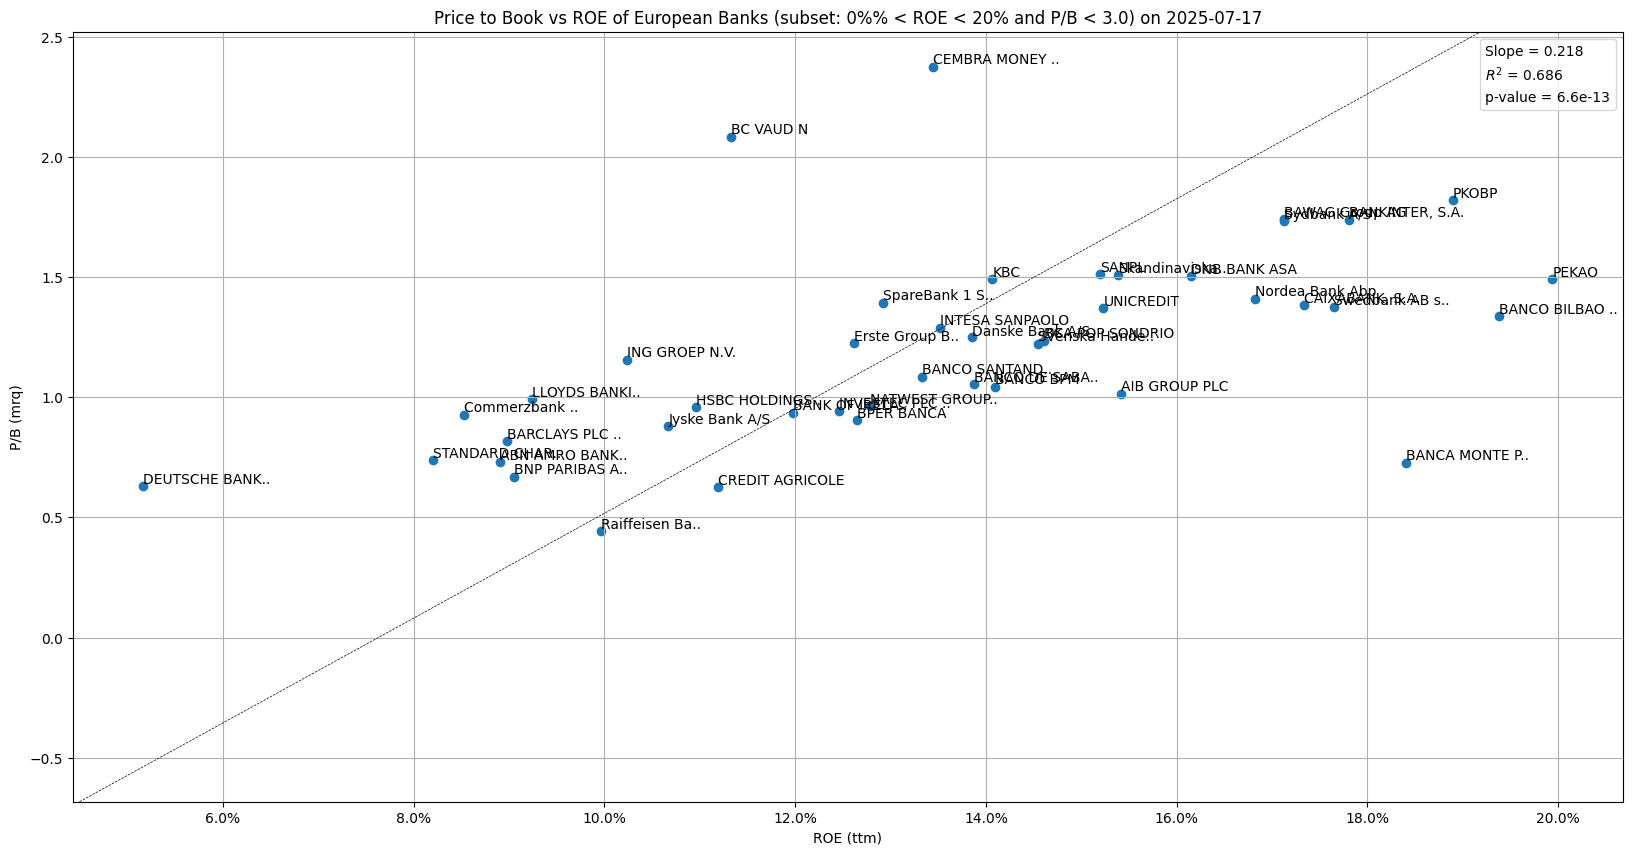

In [31]:
# Define the subset to zoom into
roe_cutoff = (0, .2)
pb_cutoff = 3.

# Reusing linear regression data from the whole set of banks
roe_pb_subset, _, _, _, _ = display_roe_pb(roe_pb, roe_cutoff, pb_cutoff, (slope, intercept, rvalue, pvalue))

# Uncomment if you want to recalculate linear regression for the subset
# roe_pb_subset, slope, intercept, rvalue, pvalue = display_roe_pb(roe_pb, roe_cutoff, pb_cutoff)

In [32]:
print_cost_of_equity(roe_pb_subset, slope, g)

The sensitivity of P/B to ROE for European banks: 0.22
This means that for every percentage point improvement in ROE, the bank's P/B increases by 0.22

From the above equation it also means that an approximate cost of equity for these banks is: 9.60%
['INGA.AS', 'ABN.AS', 'DBK.DE', 'CBK.DE', 'BNP.PA', 'ACA.PA', 'KBC.BR', 'BIRG.IR', 'A5G.IR', 'BBVA.MC', 'BKT.MC', 'CABK.MC', 'SAB.MC', 'SAN.MC', 'EBS.VI', 'BG.VI', 'RBI.VI', 'NDA-FI.HE', 'ISP.MI', 'UCG.MI', 'BAMI.MI', 'BPE.MI', 'BMPS.MI', 'BPSO.MI', 'HSBA.L', 'BARC.L', 'LLOY.L', 'NWG.L', 'INVP.L', 'STAN.L', 'BCVN.SW', 'CMBN.SW', 'SEB-A.ST', 'SWED-A.ST', 'SHB-A.ST', 'DANSKE.CO', 'SYDB.CO', 'JYSK.CO', 'DNB.OL', 'SB1NO.OL', 'PEO.WA', 'PKO.WA', 'SPL.WA']


Finally let's zoom into the cluster of banks with ROE between 8% and 18% and P/B less than 2. I will also construct a regression line to determine the sensitivity of P/B to ROE changes.

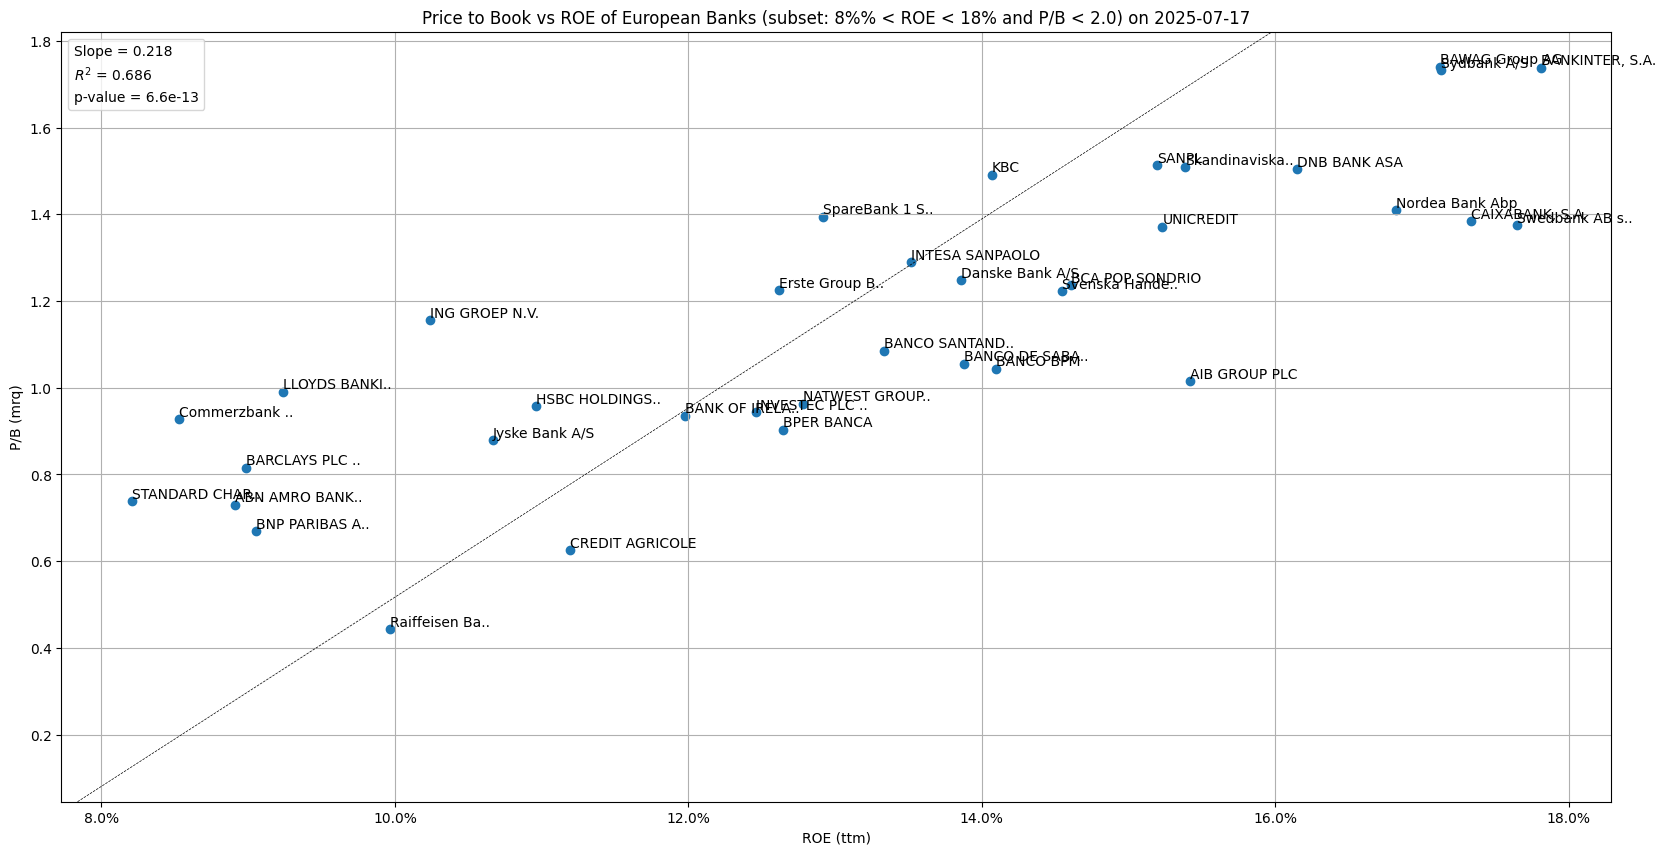

In [33]:
roe_cutoff = (0.08, .18)
pb_cutoff = 2.

_, _, _, _, _ = display_roe_pb(roe_pb, roe_cutoff, pb_cutoff, (slope, intercept, rvalue, pvalue))

# Uncomment if you want to recalculate linear regression for the subset
# roe_pb_subset, slope, intercept, rvalue, pvalue = display_roe_pb(roe_pb, roe_cutoff, pb_cutoff)

#### Changes in capitalization and market share for the whole set of consituent banks

In [34]:
all_now = stoxx600_banks_metrics.get_top_n_capitalization_companies_for_day(
    100, merge_additional_share_classes=True)
all_year_ago = stoxx600_banks_metrics.get_top_n_capitalization_companies_for_month(
    100, stoxx600_banks_metrics.data.index[-1] - pd.DateOffset(months=+12))

In [35]:
all_today = pd.concat([all_year_ago.Capitalization, all_now.Capitalization], axis=1) / 1e9
all_today.columns = [stoxx600_banks_metrics.CAPITALIZATION + sfx for sfx in [' year ago', ' now']]
all_today_pct = pd.concat([all_year_ago.iloc[:,1], all_now.iloc[:,1]], axis=1)

In [36]:
pd.options.display.float_format = (lambda x: '{:.2%}'.format(x) if x < .3 else '€{:,.2f}bn'.format(x))
pd.options.display.max_rows = 50

In [37]:
all_today

,Capitalization year ago,Capitalization now
HSBA.L,€147.99bn,€188.06bn
BNP.PA,€71.96bn,€87.19bn
SAN.MC,€69.40bn,€110.29bn
ISP.MI,€65.78bn,€86.61bn
UCG.MI,€60.73bn,€89.72bn
BBVA.MC,€56.92bn,€76.15bn
INGA.AS,€54.20bn,€58.10bn
LLOY.L,€43.45bn,€54.06bn
ACA.PA,€41.46bn,€48.46bn
BARC.L,€39.47bn,€57.36bn


In [38]:
all_today_pct

,Market share (%),Market share (%)
HSBA.L,12.39%,11.78%
BNP.PA,6.03%,5.46%
SAN.MC,5.81%,6.91%
ISP.MI,5.51%,5.43%
UCG.MI,5.08%,5.62%
BBVA.MC,4.77%,4.77%
INGA.AS,4.54%,3.64%
LLOY.L,3.64%,3.39%
ACA.PA,3.47%,3.04%
BARC.L,3.31%,3.59%


Let's see which banks have retained or increased their share in the overall capitalization of Stoxx Europe 600 Banks.

In [39]:
# The total capitalization of Stoxx Europe 600 Banks changed by 'pct_change_over_year_all' percentage points.
all_that_kept_their_share = all_today[(all_today.iloc[:,1] - all_today.iloc[:,0])/all_today.iloc[:,0] >= pct_change_over_year_all].index

In [40]:
all_today_pct.loc[all_that_kept_their_share]

,Market share (%),Market share (%)
SAN.MC,5.81%,6.91%
UCG.MI,5.08%,5.62%
BBVA.MC,4.77%,4.77%
BARC.L,3.31%,3.59%
CABK.MC,3.25%,3.37%
NWG.L,2.78%,2.91%
DBK.DE,2.50%,3.21%
STAN.L,1.83%,2.23%
EBS.VI,1.56%,1.84%
GLE.PA,1.55%,2.42%


In [41]:
all_that_kept_their_share.to_list()

['SAN.MC',
 'UCG.MI',
 'BBVA.MC',
 'BARC.L',
 'CABK.MC',
 'NWG.L',
 'DBK.DE',
 'STAN.L',
 'EBS.VI',
 'GLE.PA',
 'CBK.DE',
 'PKO.WA',
 'ABN.AS',
 'SAB.MC',
 'BAMI.MI',
 'BPE.MI',
 'BKT.MC',
 'BMPS.MI',
 'RBI.VI',
 'BG.VI',
 'AZA.ST',
 'BPSO.MI',
 'SB1NO.OL',
 'CMBN.SW']

#### Analysis of changes in ROE to P/B

In [42]:
from pandas.tseries.offsets import QuarterEnd
import os
last_qe = QuarterEnd(0).rollback(date.today())
banks_roe = roe_pb.loc[:, 'ROE'].to_frame(last_qe.date())
banks_pb = roe_pb.loc[:, 'P/B'].to_frame(last_qe.date())


# Define disjoint subset
nordics = ['.CO', '.HE', '.OL', '.ST', '.IR', '.L']
western_eu = ['.BR', '.AS', '.DE', '.SW', '.VI', '.PA']
southern_and_cee = list({stoxx600_banks_metrics.get_exchange_suffix(ticker) for ticker in stoxx600_banks} - set(nordics) - set(western_eu))

# Define a dedicated subset for Germany, Benelux and Scandinavia
germany_blx_scandinavia = ['.CO', '.HE', '.OL', '.ST', '.AS', '.BR', '.DE']

In [43]:
# if os.path.isfile(os.path.expanduser(f'~/historical_equity_data/stoxx600_banks_roe.cvs')):
#     f = pd.read_csv(f'~/historical_equity_data/stoxx600_banks_roe.cvs', index_col=0)
#     banks_roe = pd.concat([banks_roe, f], axis=1)
#     banks_roe.set_axis(pd.DatetimeIndex(banks_roe.columns), axis=1)

# if os.path.isfile(os.path.expanduser(f'~/historical_equity_data/stoxx600_banks_pb.cvs')):
#     f = pd.read_csv(f'~/historical_equity_data/stoxx600_banks_pb.cvs', index_col=0)
#     banks_pb = pd.concat([banks_pb, f], axis=1)
#     banks_pb.set_axis(pd.DatetimeIndex(banks_pb.columns), axis=1)

In [44]:
# # The eldest quarter
# roe_lq = banks_roe.iloc[:,-1]
# pb_lq = banks_pb.iloc[:,-1]
# roe_lq = roe_lq.loc[roe_pb_subset.index]
# pb_lq = pb_lq.loc[roe_pb_subset.index]

# roe_pb_subset_lq = pd.concat([roe_lq, pb_lq], axis=1)
# roe_pb_subset_lq.columns = roe_pb_subset.columns

# slope_lq, intercept_lq = scipy.stats.linregress(roe_pb_subset_lq.dropna().iloc[:,0].to_list(),
#                                                 roe_pb_subset_lq.dropna().iloc[:,1].to_list())[0:2]

# idx_exclude = roe_pb_subset_lq[roe_pb_subset_lq.ROE < 0].index
# roe_pb_subset = roe_pb_subset.loc[~roe_pb_subset.index.isin(idx_exclude)]
# roe_pb_subset_lq = roe_pb_subset_lq.loc[~roe_pb_subset_lq.index.isin(idx_exclude)]

In [45]:
# def display_roe_pb_transitions(roe_pb_subset, roe_pb_subset_lq,
#                                subset=['.AS', '.BR', '.CO', '.DE', '.HE', '.IR', '.L', '.MC',
#                                        '.MI', '.OL', '.PA', '.ST', '.SW', '.VI', '.WA'], subset_name=None,
#                                display_slopes=False):
#     roe_pb_subset = roe_pb_subset[roe_pb_subset.index.str.endswith(tuple(subset))]
#     roe_pb_subset_lq = roe_pb_subset_lq[roe_pb_subset_lq.index.str.endswith(tuple(subset))]
#     fig, ax = plt.subplots(figsize=(20, 10))
#     sc = ax.scatter(x=roe_pb_subset.iloc[:,0], y=roe_pb_subset.iloc[:,1])
#     sc3 = ax.scatter(x=roe_pb_subset_lq.iloc[:,0], y=roe_pb_subset_lq.iloc[:,1], marker='h', color='#2ca02c')
    
#     for index, row in roe_pb_subset_lq.iterrows():
#         x_start, x_end = row.iloc[0], roe_pb_subset.loc[index, roe_pb_subset.columns[0]]
#         y_start, y_end = row.iloc[1], roe_pb_subset.loc[index, roe_pb_subset.columns[1]]
#         ax.plot([x_start, x_end], [y_start, y_end], ls='--', color='#1f77b4', lw=.5)
#         if np.all(~np.isnan(np.array([x_start, y_start, x_end, y_end]))):
#             ax.annotate(
#                 '',  # No text
#                 xy=(x_end, y_end),      # Arrow tip (end point)
#                 xytext=(x_start, y_start),  # Arrow tail (start point)
#                 arrowprops=dict(arrowstyle='-|>,head_width=.3,head_length=.7', color='#1f77b4', lw=0.5, linestyle='--')
#             )

#     if display_slopes:
#         x_min = roe_pb_subset.iloc[:,0].min()
#         ax.axline((x_min, intercept + slope * x_min), slope=slope, linestyle='--', color='k', linewidth=.5)
#         plt.text(x_min, intercept + slope * x_min + .02, f'Slope = {slope/100:.2f}')
        
#         x_min_lq = roe_pb_subset_lq.iloc[:,0].min()
#         ax.axline((x_min_lq, intercept_lq + slope_lq * x_min_lq), slope=slope_lq, linestyle='--', color='g', linewidth=.5)
#         plt.text(x_min_lq, intercept_lq + slope_lq * x_min_lq + .02, f'Slope = {slope_lq/100:.2f}')
    
#     # Add labels to designate each bank
#     for ticker, (roe, pb) in roe_pb_subset.iterrows():
#         plt.text(roe, pb, ticker_to_name[ticker], ha='left', va='bottom')
        
#     ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
#     ax.set_xlabel(roe_pb.columns[0] + TTM_SUFFIX)
#     ax.set_ylabel(roe_pb.columns[1] + MRQ_SUFFIX)
#     ax.set_title(f'Price to Book vs ROE of European Banks ' + (f'(subset: {subset_name}) ' if subset_name else '') +
#                  f'on {stoxx600_banks_metrics.capitalization.index[-1]:%Y-%m-%d}')
#     ax.legend([sc, sc3], [f'Quarter end {qe}' for qe in banks_roe.columns[[0, -1]]])
#     ax.grid(True)

In [46]:
# display_roe_pb_transitions(roe_pb_subset, roe_pb_subset_lq, nordics, 'Nordics')

In [47]:
# display_roe_pb_transitions(roe_pb_subset, roe_pb_subset_lq, western_eu, 'Western Europe')

In [48]:
# display_roe_pb_transitions(roe_pb_subset, roe_pb_subset_lq, southern_and_cee, 'Southern Europe and CEE')

In [49]:
# display_roe_pb_transitions(roe_pb_subset, roe_pb_subset_lq, germany_blx_scandinavia, 'Germany, Benelux, Scandinavia')